In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os

def git_get():
    '''Get latest version from github'''
    os.system("git remote update")
    os.system("git pull")
    
def git_put(message):
    '''Adds/commits this notebook'''
    os.system("git add ML_projekt1.ipynb")
    os.system('git commit -m "{}"'.format(message))
    os.system("git push")

# IMDB Movie Analysis

In [2]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

## Analysis goals

In this analysis we will explore the world of movies through a 5000+ entries dataset from IMDB.com. The ultimate goal for this dataanalysis is to determine which features make a movie "successful". The definition of "successful" is of course a bit vague, but during this dataanalysis we will define success as high popularity and/or gross revenue. We will also be exploring grouping of movies through a variety of machine learning methods.

## Initial assumptions

Our initial assumption is that more popular movies in general generate a bigger revenue, since we assume popularity is highly correlated with the total number of consumers for that specific movie.

## Method of analysis

This analysis uses the OSEMN model, which is an acronym for: Obtain, Scrub, Explore, Model, and iNterpret.

https://machinelearningmastery.com/how-to-work-through-a-problem-like-a-data-scientist/

# 1. Obtain Data

## Dataset source and description

The IMDB Movie dataset from Kaggle.com, contains information from 5000 movies, obtained by webscraping IMDB.com. Note that at the time of writing, the dataset was recently removed from Kaggle and replaced with a new dataset which is not compatible with this notebook. Kaggle hosts a multitude of "kernels" (runable data science papers) using this dataset, with titles such as: "film recommendation engine", "Movie Recommendations" and "Categorizing actors".

https://www.kaggle.com/tmdb/tmdb-movie-metadata/data

# 2. Scrub Data

## Data preparation, cleaning and structure

Throughout this analysis we will handle the dataset in a dictionary named "data". It is the hope of the authors that this structure will make code-snippets more readable and remove the need for redundant comment/explanations (this paragraph excluded). In addition to the raw data, we will prepare two other versions of our dataset: "No_na" - where entries containing N/A data have been removed and "numerical" which contain only numerical data columns. We justify this by assuming representation similarity in columns such as "director name" and "director facebook likes". This is due to the fact that "being James Cameron" doesn't mean anything, but having a "relavant attribute" such as popularity is expected to have a higher impact.

In [3]:
data = {}
data['raw'] = pd.read_csv("movie_metadata.csv")
data['no_na'] = data['raw'].dropna();
data['n_removed_na'] = data['raw'].shape[0] - data['no_na'].shape[0]
data['numerical'] = data['no_na'].select_dtypes(exclude=['object']) #.fillna(value=0, axis=1)
print(f"Number of removed rows: {data['n_removed_na']} out of {data['raw'].shape[0]}")

Number of removed rows: 1287 out of 5043


## Post-cleaning data validation

As indicated above, many rows containing N/A-data was removed from the dataset. It is acknowledged by the authors that may reduce the prediction generalizability, but at the time of writing this decision seems justifiable in comparisson to potentially mishandling N/A's.

# 3. Explore Data

## Summary statistics of numerical data

A summary of the statistics are given below, including the mean, standard deviation, and the different quartiles for each attribute. These values will be relevant later, when interpreting results.

In [110]:
data['numerical'].describe().round(decimals=2)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,3756.00,3756.00,3756.00,3756.00,3756.00,3.756000e+03,3756.00,3756.00,3756.00,3756.00,3.756000e+03,3756.00,3756.00,3756.00,3756.00,3756.00
mean,167.38,110.26,807.34,771.28,7751.34,5.261282e+07,105826.73,11527.10,1.38,336.84,4.623685e+07,2002.98,2021.78,6.47,2.11,9353.83
std,123.45,22.65,3068.17,1894.25,15519.34,7.031787e+07,152035.40,19122.18,2.04,411.23,2.260103e+08,9.89,4544.91,1.06,0.35,21462.89
min,2.00,37.00,0.00,0.00,0.00,1.620000e+02,91.00,0.00,0.00,4.00,2.180000e+02,1927.00,0.00,1.60,1.18,0.00
25%,77.00,96.00,11.00,194.00,745.00,8.270233e+06,19667.00,1919.75,0.00,110.00,1.000000e+07,1999.00,384.75,5.90,1.85,0.00
50%,138.50,106.00,64.00,436.00,1000.00,3.009311e+07,53973.50,4059.50,1.00,210.00,2.500000e+07,2004.00,685.50,6.60,2.35,227.00
75%,224.00,120.00,235.00,691.00,13000.00,6.688194e+07,128602.00,16240.00,2.00,398.25,5.000000e+07,2010.00,976.00,7.20,2.35,11000.00
max,813.00,330.00,23000.00,23000.00,640000.00,7.605058e+08,1689764.00,656730.00,43.00,5060.00,1.221550e+10,2016.00,137000.00,9.30,16.00,349000.00


## Catagorical data

Since our dataset contains categorical data we wish to get a quick overview of these columns.

In [5]:
data['raw'].dtypes.value_counts()

float64    13
object     12
int64       3
dtype: int64

## Outlier detection

For numerical data we wish to see if there are outliers. According to the "Central limit theorem" we should expect most distributions to tend towards a normal distribution.

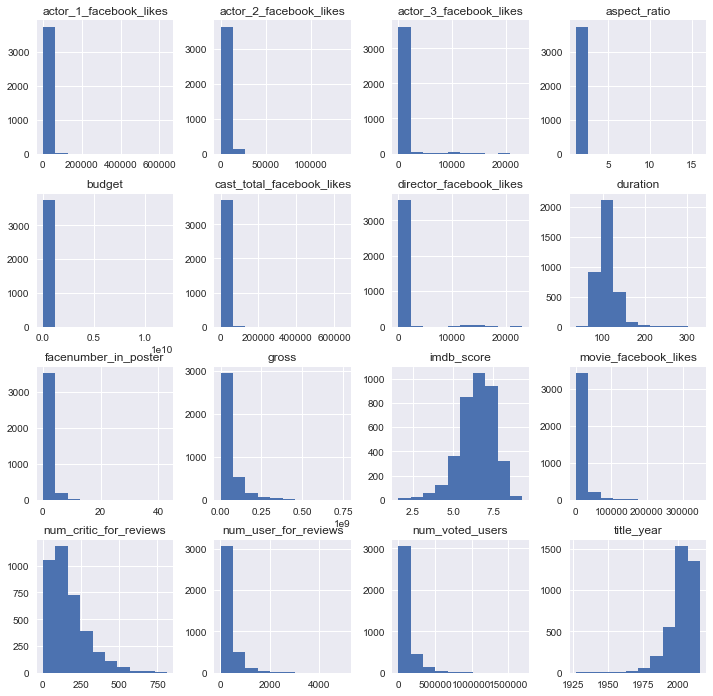

In [14]:
data['no_na'].hist(figsize=(12,12));

From our histograms we can see that most of dataset catagories contain outliers. For instance budget seems to have an unlikely high outlier, indicated by the x-axis scaling.

In [124]:
data['raw'].loc[data['raw']['budget'].idxmax()]

color                                                                    Color
director_name                                                     Joon-ho Bong
num_critic_for_reviews                                                     363
duration                                                                   110
director_facebook_likes                                                    584
actor_3_facebook_likes                                                      74
actor_2_name                                                      Kang-ho Song
actor_1_facebook_likes                                                     629
gross                                                              2.20141e+06
genres                                              Comedy|Drama|Horror|Sci-Fi
actor_1_name                                                         Doona Bae
movie_title                                                          The Host 
num_voted_users                                     

The highest movie budget is from a Korean movie called "The Host". A further investigation on IMDB.com shows this is because the budget currency is described in KRW (Korean Won).

## Attribute overview

In the following table all the 28 different attributes are explained and it's shown whether they are discrete or continous together with their level of measurement.  


<table valign="left">
  <tr>
    <th>Attribute</th>
    <th>Explanation</th>
    <th>Discrete/continous</th>
    <th>Nominal/Ordinal/Interval/Ratio</th>
  </tr>
  <tr>
    <td>color</td>
    <td>Is the movie in color or black and white</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>director_name</td>
    <td>Name of the director</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>num_critic_for_reviews</td>
    <td>Number of critics reviews</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>duration</td>
    <td>Duration of the movie</td>
    <td>Continous</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>director_facebook_likes</td>
    <td>The directors amount of facebook likes</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>actor_3_facebook_likes</td>
    <td>Third actor likes on Facebook</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>actor_2_name</td>
    <td>Second actor's name</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>actor_1_facebook_likes</td>
    <td>First actor likes on Facebook</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>gross</td>
    <td>Gross income of the movie</td>
    <td>Continous</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>genres</td>
    <td>The movies genre </td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>actor_1_name</td>
    <td>First actor's name</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>movie_title</td>
    <td>Title of the movie</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>num_voted_users</td>
    <td>Number of votes at IMDB</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>cast_total_facebook_likes</td>
    <td>Total Facebook likes for the cast</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>actor_3_name</td>
    <td>Third actor's name</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>facenumber_in_poster</td>
    <td>Amount of faces in the poster</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>plot_keywords</td>
    <td>Keyword related to movie plot</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>movie_imdb_link</td>
    <td>The movies imdb link</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>num_user_for_reviews</td>
    <td>Number of user reviews</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>language</td>
    <td>Spoken language</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>country</td>
    <td>Country of origin </td>
    <td>Discrete</td>
    <td>Nominal </td>
  </tr>
  <tr>
    <td>content_rating</td>
    <td>Content rating</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>budget</td>
    <td>The budget of the movie</td>
    <td>Continous</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>title_year</td>
    <td>Release date</td>
    <td>Discrete</td>
    <td>Interval</td>
  </tr>
  <tr>
    <td>actor_2_facebook_likes</td>
    <td>Second actor likes on Facebook</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>imdb_score</td>
    <td>Score on imdb (voted by users)</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>aspect_ratio</td>
    <td>Aspect ratio of the movie</td>
    <td>Discrete</td>
    <td>Nominal </td>
  </tr>
  <tr>
    <td>movie_facebook_likes</td>
    <td>Total Facebook likes of the movie</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
</table>

By grouping the dataset features, we can select the correct machine learning strategy based on the table below.

<table>
  <tr>
    <th></th>
    <th>Supervised</th>
    <th>Unsupervised</th>
  </tr>
  <tr>
    <td>Continuous</td>
    <td>Regression</td>
    <td>Clustering</td>
  </tr>
  <tr>
    <td>Discrete</td>
    <td>Classification</td>
    <td>Association mining</td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Anomaly detection</td>
  </tr>
</table>

<h2> Predictive tasks (supervised learning) </h2>

In machine learning there are two predictive tasks, classification and regression. 

### Classification

As the primary machine learning aim for the dataset is to predict the most succesful movie, a classification problem could be given to find out what the best movies have in common, for example the <i>imdb_score</i> is sorted in to five groups as seen in the table below:

<table style="undefined;table-layout: fixed; width: 162px">
<colgroup>
<col style="width: 89.007161px">
<col style="width: 73.007161px">
</colgroup>
  <tr>
    <th>imdb_score</th>
    <th>Movie quality</th>
  </tr>
  <tr>
    <td>[0-2]</td>
    <td>Horrible</td>
  </tr>
  <tr>
    <td>[2-4]</td>
    <td>Bad</td>
  </tr>
  <tr>
    <td>[4-6]</td>
    <td>Mediocre</td>
  </tr>
  <tr>
    <td>[6-8]</td>
    <td>Good</td>
  </tr>
  <tr>
    <td>[8-10]</td>
    <td>Excellent</td>
  </tr>
</table>

With Movie quality as a class label it could be possible to see what the different qualities have in common. And from that be able to assign a previously unseen project with the correct label. 

### Regression

The other predictive task, regression, is performed on the different attributes. But before using regression on all of the attributes, one can look at a created <i>Pearson correlation matrix</i>. To get an idea of which attributes correlate. And then do the regression on these.
It could for example be possible to predict the <i>gross</i> as a function of <i>budget</i> and <i>cast_total_facebook_likes</i>.

<h2> Descriptive tasks (unsupervised learning) </h2>

The other kind of tasks used in machine learning is the descriptive tasks, which differs from the predictive tasks since they are unsupervised.  

### Clustering

The first descriptive task is clustering, where the goal is to group the given data objects into clusters where the objects within each cluster are similar. A number of features are associated with the objects, and from that the similarity between the objects is defined.

eksempel!"#¤!"#!"¤!"#

### Association rule mining

Another desriptive task is association rule mining, where the goal is to produce dependency rules from seemingly unrelated data. 
An association rule has an antecedent (if) and from that a consequent (then). An antecedent is found from the data and the consequent is then calculated from a combination of the antecedent. 

An association rule from this dataset could be with items from <i>genres</i>:
<p>{sci-fi,thriller} &rarr; {action}</p>





 

### Anomaly detection

The last descriptive task, is anaomaly detection which for example can be used to find outliers.
For instance a movie with a very high gross, such as Avatar, could deviate from other movies since the gross is extremely high compared to a mean gross. 

## Principle Component Analysis: Preprocessing

In our Principe Component Analysis we wish to reduce the number of dimensions in our dataset without losing too much of the data. In this method of analysis it is worth noting, that while we may be able to reduce the number of dimensions, these might not be easily, if at all, interpretable.

Before doing a Principle Component Analysis we wish to extract only numerical data our dataset as well as find eigenvalues and eigenvectors. From this information we can generate a visualization of the individual and cumulative variance explained by the eigenvectors. This will be important for determining a suitable number of components for our analysis.

In [7]:
data['X_std'] = StandardScaler().fit_transform(data['numerical'].values)
data['covariance'] = np.cov(data['X_std'].T)
data['eigenvalues'], data['eigenvectors'] = np.linalg.eig(data['covariance'])
data['eigenvalues_variance_explained'] = [(i/data['eigenvalues'].sum())*100 for i in sorted(data['eigenvalues'], reverse=True)]

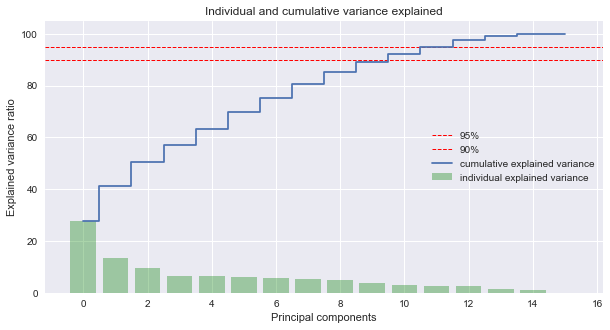

In [8]:
plt.figure(figsize=(10, 5))
plt.bar(range(16), data['eigenvalues_variance_explained'], alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.axhline(y=95, linewidth=1, color='r', linestyle='dashed', label="95%")
plt.axhline(y=90, linewidth=1, color='r', linestyle='dashed', label="90%")
plt.step(range(16), np.cumsum(data['eigenvalues_variance_explained']), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Individual and cumulative variance explained')
plt.show()

From this plot we can see that using 10 components, our model will be able to explain 90% - 95% of the total variance. So this looks promising for our analysis as we will be able to reduce our total dimensions from 16 to 10.

## Regression: Preprocessing

Create correlation matrix from numerical features. On this plot we hide the diagonal and upper half, and highlight all correlations above 0.5, or below -0.5.

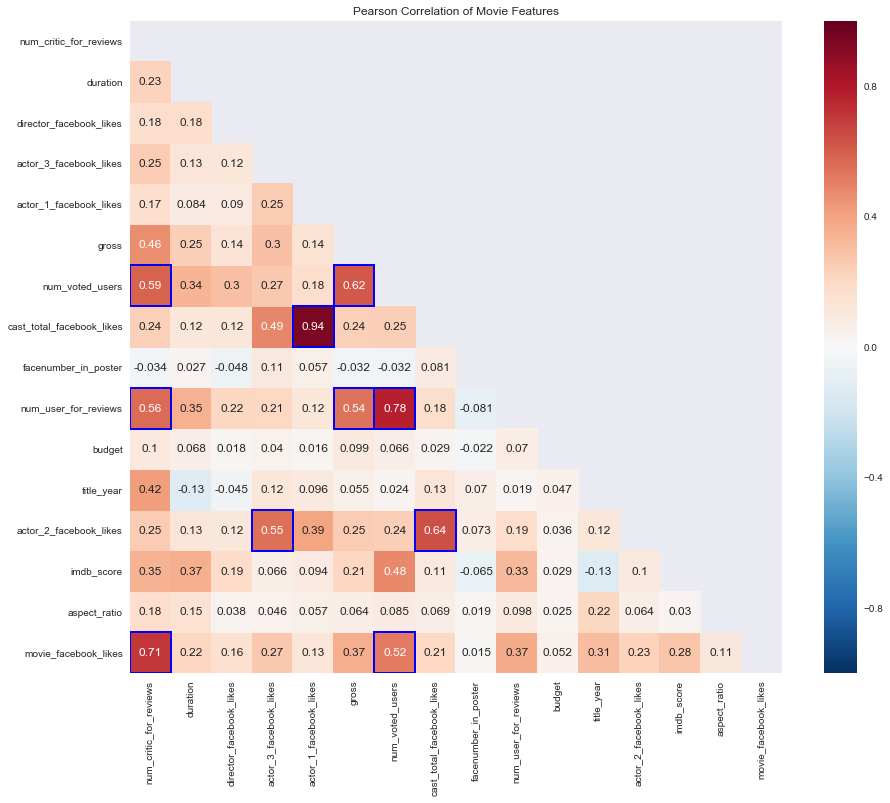

In [9]:
data['numerical_correlation'] = data['numerical'].corr()
plt.subplots(figsize=(15, 12))
plt.title('Pearson Correlation of Movie Features')

# Mask to remove diagonal and upper half
mask = np.zeros_like(data['numerical_correlation'], dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(data['numerical_correlation'],vmax=1,square=True,annot=True,mask=mask);


for cell in ax.texts:
    if (abs(float(cell.get_text())) > 0.5):
        ax.add_patch(Rectangle((int(cell.get_position()[0]-0.5), int(cell.get_position()[1]-0.5)), 1, 1, fill=False, edgecolor='blue', lw=2))

plt.show()

From our correlation matrix (heatmap), we can see some surprising correlations. Imdb_score and budget do not seem to correlate with anything. On the other hand there is good correlation between "gross", "num_voted_users" and "num_user_for_reviews".

## Principle Component Analysis: Analysis

The goal for our PCA is to create a new set of dimensions.

In [145]:
pca = PCA(n_components=10)
data['PCA10'] = pca.fit_transform(data['X_std'])

In [148]:
pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.362440,0.207521,0.157732,0.251712,0.221450,0.317211,0.385512,0.283258,0.004337,0.340108,0.057476,0.104975,0.262336,0.224365,0.091949,0.318098
1,-0.154194,-0.177734,-0.094453,0.278092,0.463158,-0.134991,-0.239589,0.505795,0.161038,-0.256853,-0.037041,0.117232,0.365821,-0.238896,-0.006977,-0.120176
2,-0.330901,0.272510,0.208846,0.007903,0.166501,0.017868,0.094186,0.150565,-0.093013,0.074287,-0.067276,-0.666636,0.063824,0.273229,-0.282531,-0.302210
3,-0.059230,0.474262,0.127842,-0.136565,0.076515,-0.246248,-0.101489,0.021862,0.350118,-0.108786,-0.067809,0.019088,-0.067790,0.191753,0.688959,-0.062417
4,0.044003,-0.060543,0.118181,-0.293047,0.291789,-0.116007,-0.065505,0.165750,-0.754693,-0.018235,0.318077,0.094422,-0.105750,0.053235,0.253928,-0.075595
5,-0.083645,0.156811,-0.158278,0.136836,-0.113997,0.127486,-0.037790,-0.053712,0.200152,0.005387,0.902110,-0.089398,0.066855,-0.102459,0.010454,-0.118805
6,0.045743,0.090730,-0.849084,-0.285988,0.254021,0.118125,0.067250,0.124596,0.060044,0.124546,-0.082931,-0.063899,-0.168814,0.169853,-0.020948,-0.023506
7,-0.164878,0.059441,-0.228887,0.323530,-0.238600,0.309118,0.025208,-0.089696,-0.327885,0.180042,-0.228174,-0.143744,0.208344,-0.341127,0.464330,-0.251057
8,-0.079685,-0.251746,0.277613,-0.333661,0.255540,0.304377,0.204105,0.091269,0.313624,0.307235,0.008518,-0.005196,-0.305867,-0.418076,0.110463,-0.246055
9,-0.027314,-0.708250,-0.033664,0.077386,-0.074923,-0.024578,0.163241,-0.030165,0.131196,-0.031451,0.086225,-0.189596,0.105270,0.511973,0.331270,-0.110538


The above table outlines our new dimensions in terms of their attributes similarity, for instance component 0 correlates more closely to attributes 0 than attributes 2.

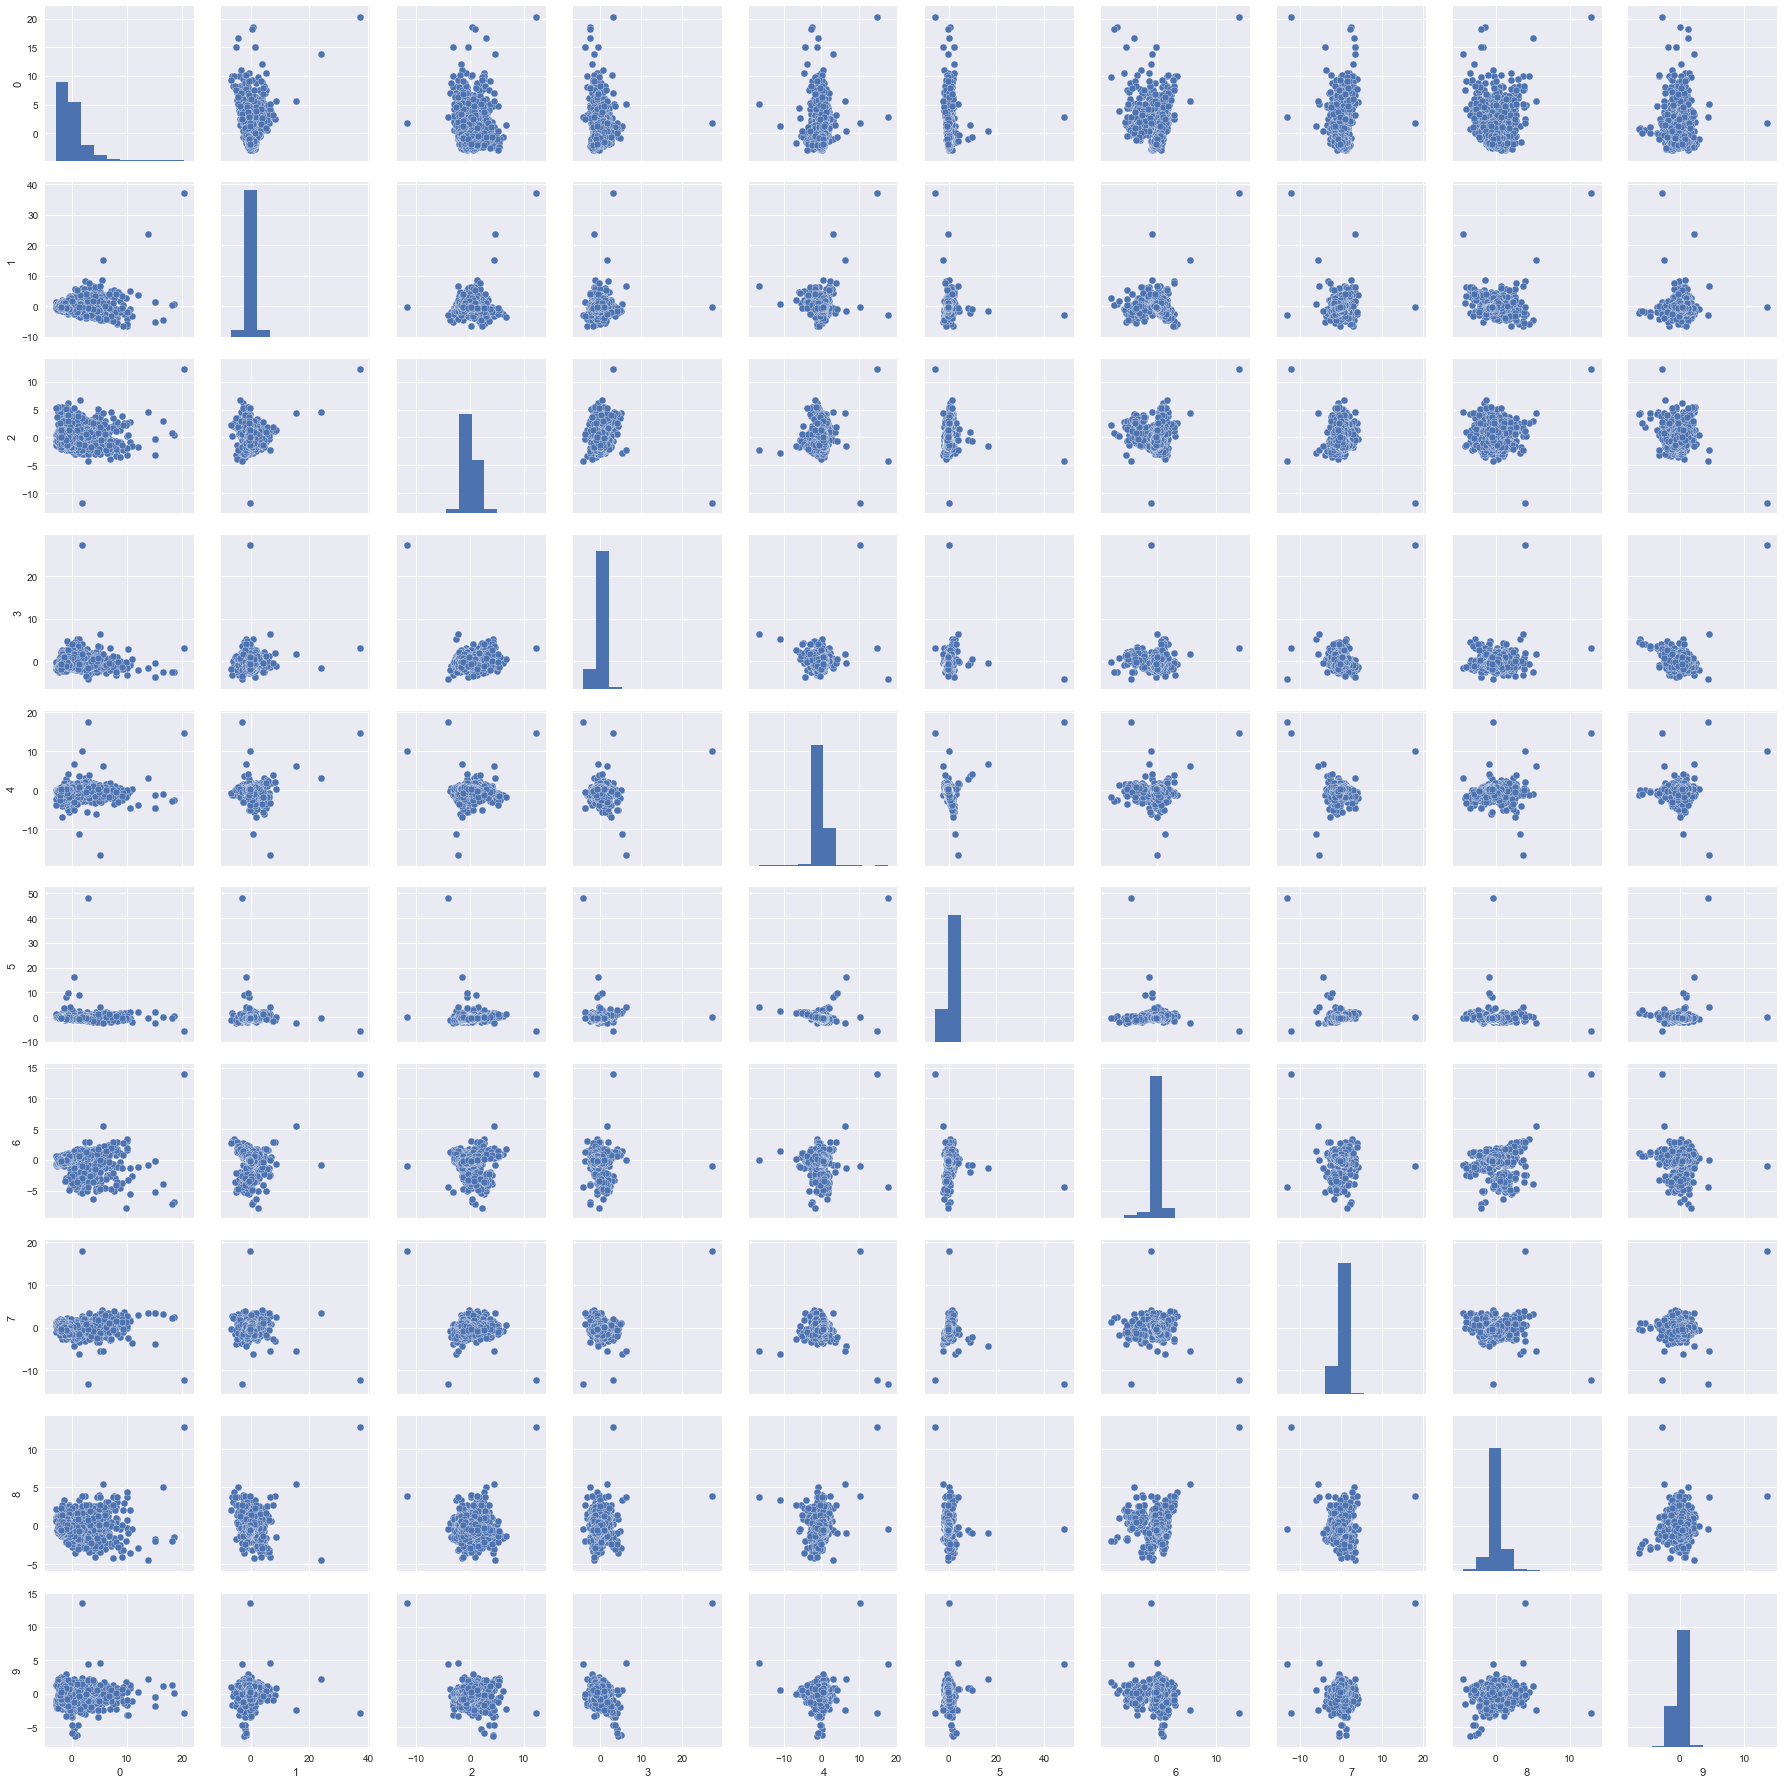

In [150]:
sns.pairplot(pd.DataFrame(data['PCA10']));

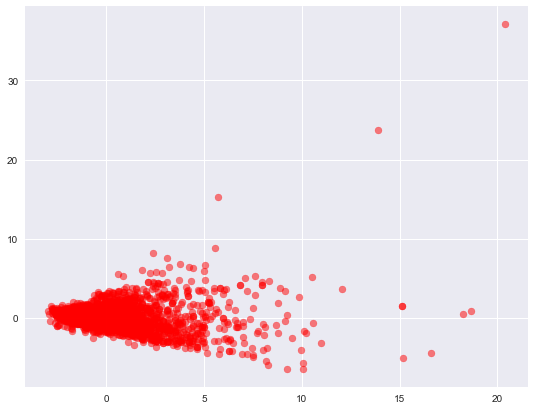

In [13]:
plt.figure(figsize = (9,7))
plt.scatter(data['PCA10'][:,0], data['PCA10'][:,1], c='red',alpha=0.5)
#plt.ylim(-10,30)
plt.show()

By ploting component 0 against 1 we cannot really see anything useful.

# Regression: Preliminary validation

From our correlation matrix we find that: "num_voted_users", "num_critic_for_reviews" and "gross" have a positive correlation that may be work investigating. In order to validate our data, we check how many entries have a "reasonable" value: num_voted_users should be above 10000 users, num_critic_for_reviews should be more than 50 reviews, and gross should be above 5000000 USD.

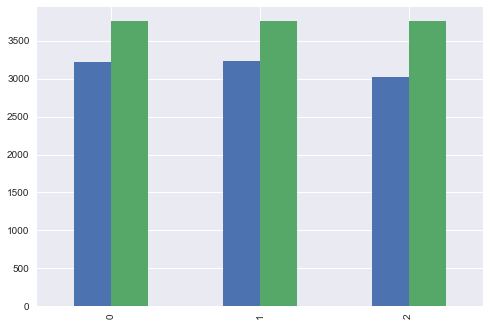

In [105]:
a1 = data['numerical'].loc[data['numerical']['num_voted_users'] > 10_000].shape[0]
a2 = data['numerical']['num_voted_users'].shape[0]
b1 = data['numerical'].loc[data['numerical']['num_critic_for_reviews'] > 50].shape[0]
b2 = data['numerical']['num_critic_for_reviews'].shape[0]
c1 = data['numerical'].loc[data['numerical']['gross'] > 5_000_000].shape[0]
c2 = data['numerical']['gross'].shape[0]
data['validation'] = pd.DataFrame([[a1, a2], [b1, b2], [c1, c2]])
data['validation'].columns = ["Individual", "Total"]
data['validation'].plot(kind='bar', legend=False);

From our graph we can see that the correlated values have decent data quality. This is promising for our regression analysis.

## ccc

# 4. Model

# 5. Interpret Results